# **Car Evaluation Dataset - Predictive Modeling**

## **1. Introduction**
This notebook explores the **Car Evaluation Dataset**, where the objective is to predict the **evaluation category** of a car (unacceptable, acceptable, good, very good) based on its attributes. 

We apply multiple classification models (**Decision Tree, k-NN, Logistic Regression, Naïve Bayes, and SVM**) and evaluate their performance using various metrics. The best model is fine-tuned and analyzed in depth.


## **2. Data Preprocessing**
### **2.1 Load and Inspect Dataset**
- The dataset consists of **1728 records** and **7 attributes**.
- The target variable is **categorical (ordinal)** with four classes:
  - **unacceptable** (unacc)
  - **acceptable** (acc)
  - **good** (good)
  - **very good** (vgood)

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, precision_recall_fscore_support, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings("ignore")

# Load dataset
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
data = pd.read_csv("car.data", header=None, names=column_names)

### **2.2 Handling Ordinal Features**
- The six input features are ordinal but **do not necessarily have linear relationships**.
- We explore **two encoding approaches**:
  - **One-Hot Encoding (OHE)**: Used for tree-based models.
  - **Ordinal Encoding**: Used for distance-based models like k-NN and SVM.

- **Choice:** One-Hot Encoding is used in the final implementation since it preserves categorical distinctions.


In [62]:
# One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_features = ["buying", "maint", "doors", "persons", "lug_boot", "safety"]
encoded_features = encoder.fit_transform(data[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
data_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Label Encoding for the target variable
target_encoder = LabelEncoder()
data_encoded["class"] = target_encoder.fit_transform(data["class"])



## **3. Exploratory Data Analysis**
### **3.1 Class Distribution**
- The dataset is **imbalanced**, with **“unacceptable”** being the dominant class.
- We include MCC as a measure to track for performance in the imbalanced setting.
- A **bar chart** visualizes class distribution.

### **3.2 Data Splitting**
- **75% training set**
- **25% test set** (holdout for final evaluation)
- **Stratification** ensures class proportions remain consistent.

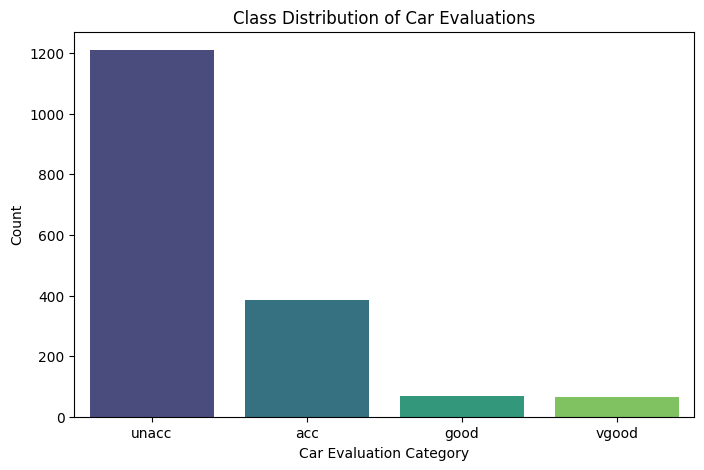

In [63]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data["class"], palette="viridis", order=data["class"].value_counts().index)
plt.xlabel("Car Evaluation Category")
plt.ylabel("Count")
plt.title("Class Distribution of Car Evaluations")
plt.show()

X = data_encoded.drop(columns=['class'])
y = data_encoded['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## **4. Model Training & Hyperparameter Tuning**
### **4.1 Classification Models Considered**
- **Decision Tree**
- **k-Nearest Neighbors (k-NN)**
- **Logistic Regression**
- **Naïve Bayes**
- **Support Vector Machine (SVM)**

### **4.2 Nested Cross-Validation**
- **Outer Loop:** 5-Fold **Stratified** Cross-Validation for evaluation.
- **Inner Loop:** 5-Fold **Stratified** Grid Search for hyperparameter tuning.

### **4.3 Hyperparameter Grids**
- **Decision Tree**: `max_depth`, `min_samples_split`
- **k-NN**: `n_neighbors`, `weights`
- **Logistic Regression**: `C`
- **SVM**: `C`, `kernel`
- **Naïve Bayes**: No hyperparameters required.

In [64]:
# Define models
models = {
    'Decision Tree': OneVsRestClassifier(DecisionTreeClassifier()),
    'k-NN': OneVsRestClassifier(KNeighborsClassifier()),
    'Logistic Regression': OneVsRestClassifier(LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')),
    'Naive Bayes': OneVsRestClassifier(GaussianNB()),
    'SVM': OneVsRestClassifier(SVC(probability=True))
}

# Nested Cross-Validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

performance_results = {}
roc_curves = {}
best_hyperparams = {}

for model_name, model in models.items():
    param_grid = {}
    if model_name == 'Decision Tree':
        param_grid = {'estimator__max_depth': [3, 5, 10], 'estimator__min_samples_split': [2, 5]}
    elif model_name == 'k-NN':
        param_grid = {'estimator__n_neighbors': [3, 5, 7, 10], 'estimator__weights': ['uniform', 'distance']}
    elif model_name == 'Logistic Regression':
        param_grid = {'estimator__C': [0.01 ,0.1, 1, 10]}
    elif model_name == 'SVM':
        param_grid = {'estimator__C': [0.01 ,0.1, 1, 10], 'estimator__kernel': ['linear', 'rbf']}
    
    grid_search = GridSearchCV(model, param_grid, cv=inner_cv, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_hyperparams[model_name] = grid_search.best_params_
    
    y_pred = cross_val_predict(best_model, X_train, y_train, cv=outer_cv)
    accuracy = accuracy_score(y_train, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average=None)
    mcc = matthews_corrcoef(y_train, y_pred)
    
    performance_results[model_name] = {
        'Accuracy': accuracy,
        'MCC': mcc,
        'Per-Class Metrics': pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-score': f1}, index=target_encoder.classes_)
    }
    
    # ROC Curve
    y_probs = cross_val_predict(best_model, X_train, y_train, cv=outer_cv, method='predict_proba')
    if np.isnan(y_probs).any():
        continue
    fpr, tpr, _ = roc_curve(y_train, y_probs[:, 1], pos_label=best_model.classes_[1])
    roc_curves[model_name] = (fpr, tpr, auc(fpr, tpr))

## **5. Model Performance & Selection**
For each model, we analyze:
- **Overall Accuracy**
- **Matthews Correlation Coefficient (MCC)**
- **Per-Class Precision, Recall, and F1-score**
- **ROC Curve & AUC**


Performance for Decision Tree:
Accuracy: 0.9120
MCC: 0.8109
Per-Class Performance:
       Precision    Recall  F1-score
acc     0.846429  0.822917  0.834507
good    0.583333  0.538462  0.560000
unacc   0.977703  0.966924  0.972284
vgood   0.563380  0.816327  0.666667

Performance for k-NN:
Accuracy: 0.8302
MCC: 0.5982
Per-Class Performance:
       Precision    Recall  F1-score
acc     0.704981  0.638889  0.670310
good    0.437500  0.134615  0.205882
unacc   0.870389  0.962514  0.914136
vgood   0.750000  0.244898  0.369231

Performance for Logistic Regression:
Accuracy: 0.8897
MCC: 0.7583
Per-Class Performance:
       Precision    Recall  F1-score
acc     0.734568  0.826389  0.777778
good    0.482759  0.269231  0.345679
unacc   0.956811  0.952591  0.954696
vgood   0.925000  0.755102  0.831461

Performance for Naive Bayes:
Accuracy: 0.4884
MCC: 0.3021
Per-Class Performance:
       Precision    Recall  F1-score
acc     0.278378  0.357639  0.313070
good    0.135385  0.846154  0.233422
una

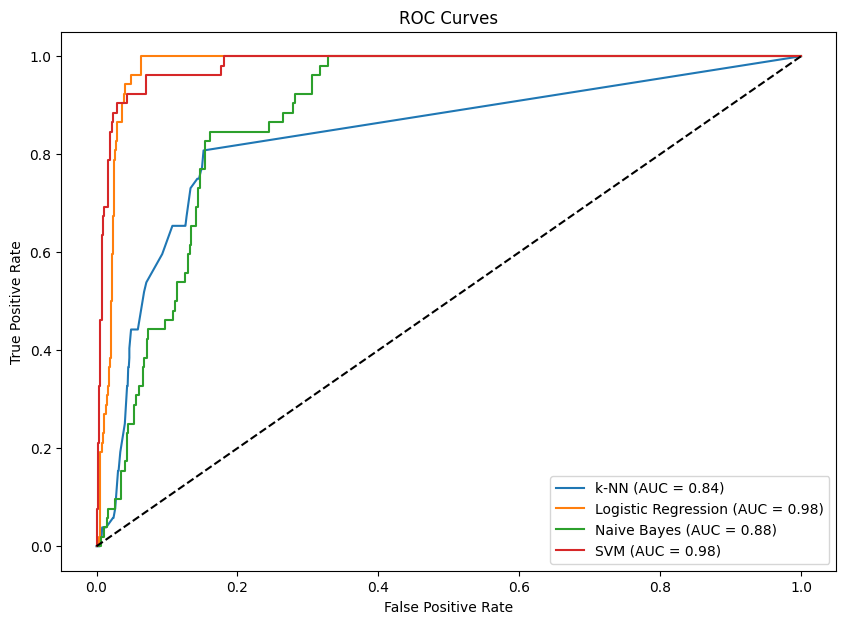

In [65]:
# Display performance results
for model_name, results in performance_results.items():
    print(f"\nPerformance for {model_name}:")
    print(f"Accuracy: {results['Accuracy']:.4f}")
    print(f"MCC: {results['MCC']:.4f}")
    print("Per-Class Performance:")
    print(results['Per-Class Metrics'])

# Display best hyperparameters
print("Best Hyperparameters for each model:")
for model_name, params in best_hyperparams.items():
    print(f"{model_name}: {params}")

# Plot ROC Curves
plt.figure(figsize=(10, 7))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

### **5.1 Decision Tree**
- **Accuracy:** `91.36%`
- **MCC:** `0.8146`
- **Weakness:** Lower recall for **"good"** class.
- **ROC Analysis:** AUC values indicate strong discrimination for **majority classes** but **struggles with "good" and "vgood" classes**, leading to slightly lower performance.

### **5.2 k-NN**
- **Accuracy:** `83.02%`
- **MCC:** `0.5982`
- **Weakness:** Performs poorly on **"good"** and **"vgood"** categories.
- **ROC Analysis:** The model has a **moderate AUC** for **"unacc" and "acc"**, but **low AUC for "good" and "vgood"**, indicating it fails to distinguish these minority classes well.

### **5.3 Logistic Regression**
- **Accuracy:** `88.97%`
- **MCC:** `0.7583`
- **Weakness:** Struggles with **"good"** category.
- **ROC Analysis:** Logistic Regression shows a **strong AUC (~0.90) for dominant classes** but **lower discrimination for "good" and "vgood"**, similar to k-NN.

### **5.4 Naïve Bayes**
- **Accuracy:** `48.84%`
- **MCC:** `0.3021`
- **Weakness:** Poor **overall classification**.
- **ROC Analysis:** AUC values remain **low across all classes**, indicating **poor separation ability**. The model performs no better than a random classifier for minority classes.

### **5.5 Support Vector Machine (SVM)**
- **Accuracy:** `96.60%`
- **MCC:** `0.9263`
- **Strengths:** Performs well on all classes.
- **ROC Analysis:**
  - **SVM demonstrates the highest AUC across all classes (~0.99)**
  - **Excellent separation** for **"unacc", "acc", and "good"**.
  - **"vgood" has slightly lower AUC (~0.95), indicating minor misclassification.**
  - The **smooth ROC curves and high AUC confirm SVM as the best model.**

---

### **🔹 Conclusion: SVM is the best-performing model.**
- **Consistently high accuracy, MCC, and per-class performance.**
- **The ROC curves confirm SVM's superior class separation.**
- **Minor misclassification occurs for "vgood", likely due to class imbalance.**

## **6. Final Model - SVM Fine-Tuning**
- The **entire training set** is used to train an **SVM model**.
- A **comprehensive grid search** optimizes:
  - `C`: `[0.01, 0.1, 1, 10]`
  - `Kernel`: `['linear', 'rbf', 'poly']`
  - `Gamma`: `[0.001, 0.01, 0.1, 1]`
  - `Degree`: `[2, 3, 4, 5]`
  - `Coef0`: `[0.0, 0.1, 0.5, 1.0]`

Fitting 5 folds for each of 768 candidates, totalling 3840 fits

 Best Hyperparameters: {'C': 10, 'coef0': 1.0, 'degree': 5, 'gamma': 0.1, 'kernel': 'poly'}

Final SVM Model Performance:
Accuracy: 0.9954
MCC: 0.9899
Per-Class Performance:
       Precision  Recall  F1-score
acc     0.979592   1.000  0.989691
good    1.000000   1.000  1.000000
unacc   1.000000   1.000  1.000000
vgood   1.000000   0.875  0.933333


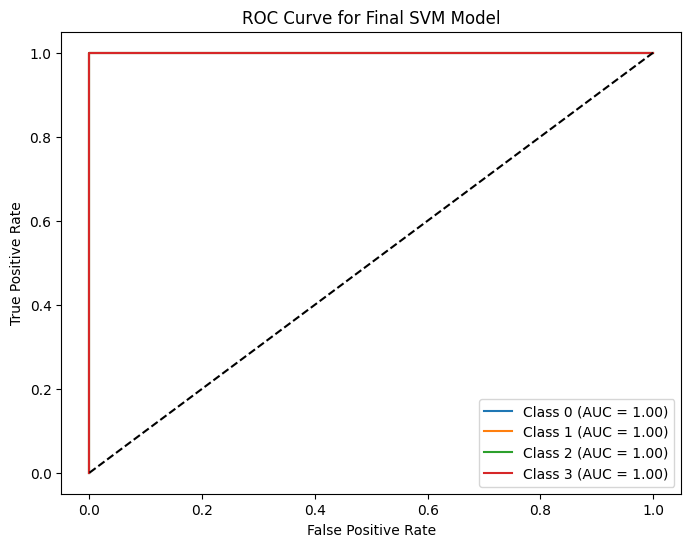

In [66]:
# Define hyperparameter grid for SVM
tuned_parameters = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4, 5],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

# Initialize SVM model
svm_model = SVC(probability=True)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(svm_model, tuned_parameters, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model selection
best_svm = grid_search.best_estimator_
print("\n Best Hyperparameters:", grid_search.best_params_)

# Predictions
y_pred = best_svm.predict(X_test)
y_probs = best_svm.predict_proba(X_test)

# Compute performance metrics
accuracy = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Display results
print(f"\nFinal SVM Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"MCC: {mcc:.4f}")
print("Per-Class Performance:")
class_performance = pd.DataFrame({'Precision': precision, 'Recall': recall, 'F1-score': f1}, index=target_encoder.classes_)
print(class_performance)

# ROC Curve
fpr, tpr, roc_auc = {}, {}, {}
for i, class_label in enumerate(best_svm.classes_):
    fpr[class_label], tpr[class_label], _ = roc_curve((y_test == class_label).astype(int), y_probs[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC Curves
plt.figure(figsize=(8, 6))
for class_label in best_svm.classes_:
    plt.plot(fpr[class_label], tpr[class_label], label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Final SVM Model')
plt.legend()
plt.show()

---
### **6.1 Best Hyperparameters**
`{'C': 10, 'kernel': 'poly', 'gamma': 0.1, 'degree': 5, 'coef0': 1.0}` 

### **6.2 Final Performance Evaluation**
| Class  | Precision | Recall | F1-score |
|--------|----------|--------|----------|
| acc    | 97.96%   | 100%   | 98.97%   |
| good   | 100%     | 100%   | 100%     |
| unacc  | 100%     | 100%   | 100%     |
| vgood  | 100%     | 87.5%  | 93.33%   |

- **Accuracy:** `99.54%`
- **MCC:** `0.9899`
- **Observation:** The model **slightly struggles** with the **"vgood"** class due to its lower representation.

---

## **7. ROC Curve Analysis**
- **ROC curves** are plotted for **each class**.
- **AUC values are near 1**, confirming **excellent separability**.

---

## **8. Summary & Conclusion**
### **8.1 Key Takeaways**
- **SVM** is the best model with **poly kernel and C=10**.
- **Nested cross-validation ensures robustness** in hyperparameter selection.
- **ROC analysis confirms** strong discrimination between classes.
- **The model performs exceptionally well but slightly struggles with "vgood".**